In [5]:
pip install pyglet==1.5

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from robotic_warehouse.warehouse import Warehouse, RewardType, Action

In [7]:
"""
(x,y)=(shelf_columns,shelf_columns)
tiny: (1, 3)
small: (2, 3)
medium: (2, 5)
large: (3, 5)
"""
shelf_rows=1
shelf_columns=3

"""
n_agents = # of robots
"""
n_agents=1

"""
difficulty:
    easy = 2
    medium = 1
    hard = 0.5
"""
request_queue_size=int(n_agents*2)

"""
RewardType(Enum):
    GLOBAL = 0
    INDIVIDUAL = 1
    TWO_STAGE = 2
"""
reward_type= RewardType.GLOBAL

msg_bits=3
max_inactivity_steps=None
max_steps=500
sensor_range=1
column_height=8

100%|██████████| 100/100 [00:01<00:00, 58.40it/s]


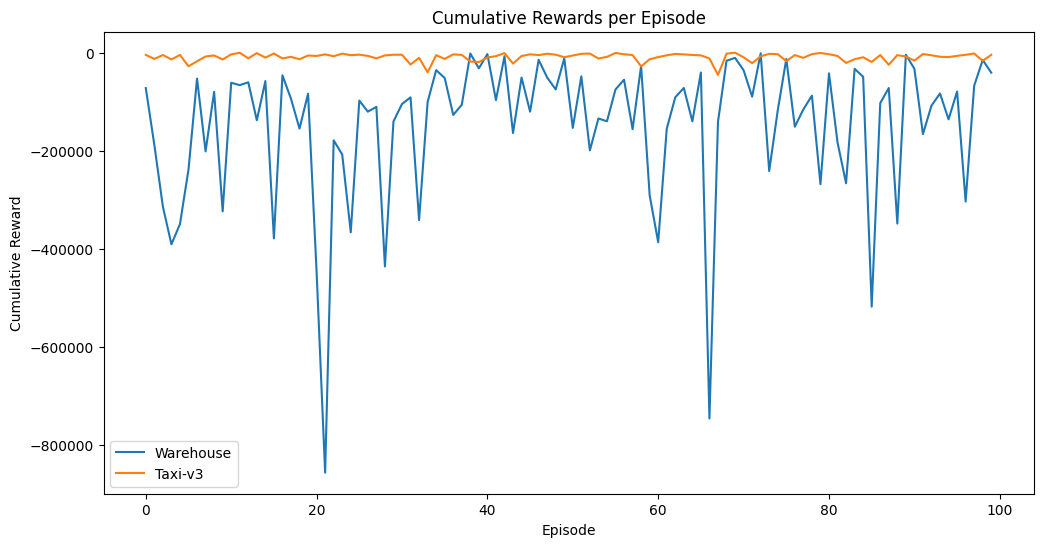

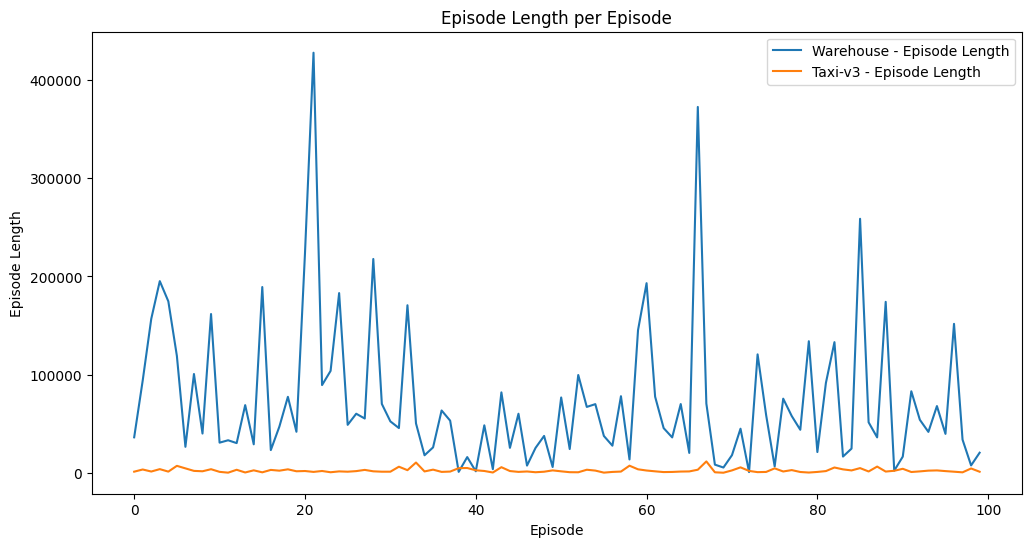

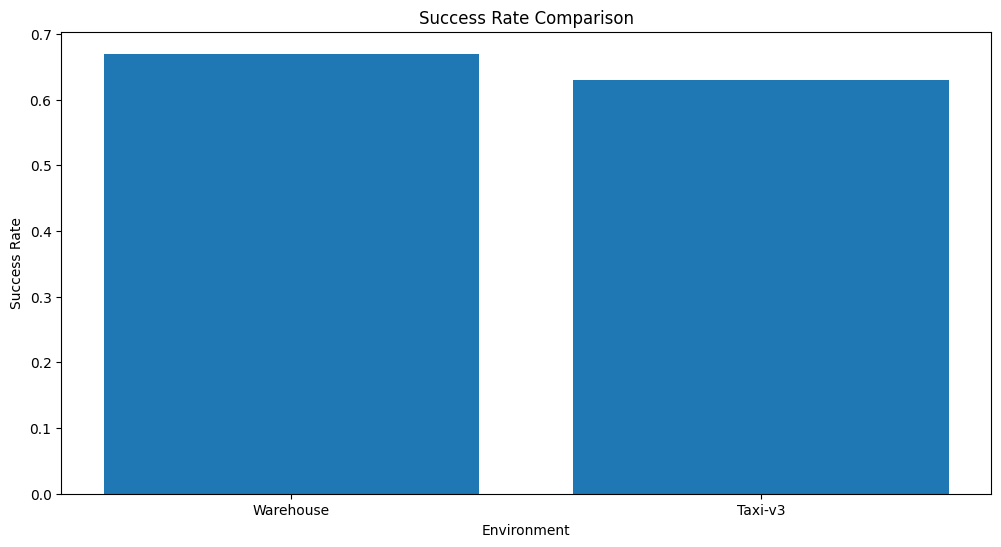

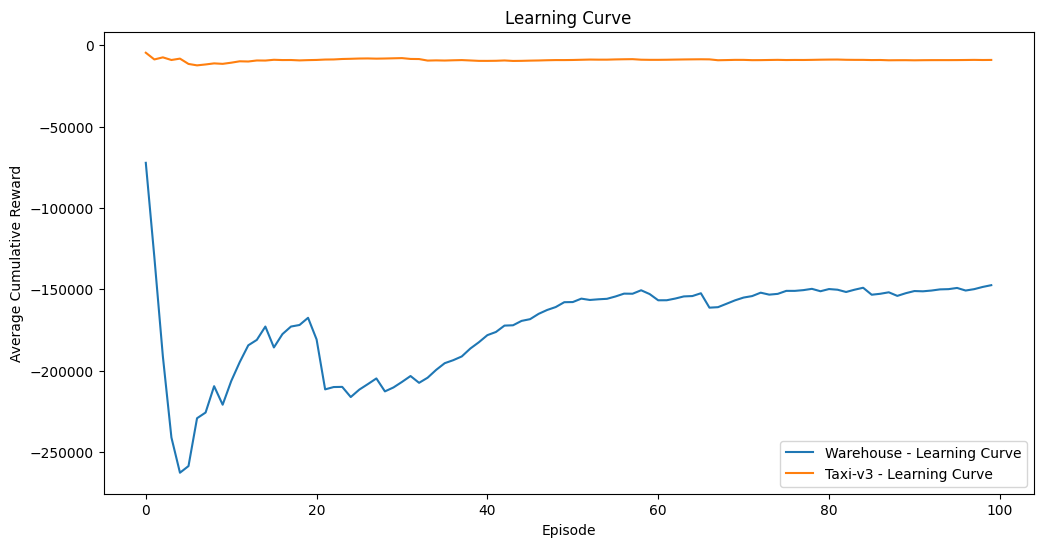

In [8]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Initialize environments
env1 = Warehouse(shelf_columns, column_height, shelf_rows, n_agents, msg_bits, sensor_range, request_queue_size, max_inactivity_steps, max_steps, reward_type)
env1.reset()
env2 = gym.make("Taxi-v3")
episodes = 100

def run_taxi_environment(env, episodes):
    episode_lengths = []
    cumulative_rewards = []
    for _ in tqdm(range(episodes)):
        total_reward = 0
        done = False
        episode_length = 0
        observation = env.reset()
        while not done:
            action = env.action_space.sample()
            observation, reward, done, info, data = env.step(action)
            total_reward += reward
            episode_length += 1
        episode_lengths.append(episode_length)
        cumulative_rewards.append(total_reward)
    return episode_lengths, cumulative_rewards

def run_warehouse_environment(env, episodes):
    episode_lengths = []
    cumulative_rewards = []
    for _ in tqdm(range(episodes)):
        total_reward = 0
        delivered = False
        episode_length = 0
        while not delivered:
            action = env.action_space.sample()
            vals = list(env.step(action))
            total_reward += vals[1][0]
            delivered=vals[4]
            episode_length += 1
        episode_lengths.append(episode_length)
        cumulative_rewards.append(total_reward)
    return episode_lengths, cumulative_rewards

def calSuccessRate(rewards,threshold):
    success_count = 0
    for reward in rewards:
        if reward>=threshold:
            success_count+=1
    success_rate=success_count/len(rewards)
    return success_rate

# Run experiments
episode_lengths_env1, cumulative_rewards_env1 = run_warehouse_environment(env1, episodes)
episode_lengths_env2, cumulative_rewards_env2 = run_taxi_environment(env2, episodes)

# Calculate average cumulative reward for learning curve
average_rewards_env1 = np.cumsum(cumulative_rewards_env1) / (np.arange(episodes) + 1)
average_rewards_env2 = np.cumsum(cumulative_rewards_env2) / (np.arange(episodes) + 1)

# thresholds for each environment
success_threshold_warehouse=sum(cumulative_rewards_env1)/len(cumulative_rewards_env1)
success_threshold_taxi=sum(cumulative_rewards_env2)/len(cumulative_rewards_env2)
success_rate_env1=calSuccessRate(cumulative_rewards_env1, success_threshold_warehouse)
success_rate_env2=calSuccessRate(cumulative_rewards_env2, success_threshold_taxi)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards_env1, label='Warehouse')
plt.plot(cumulative_rewards_env2, label='Taxi-v3')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards per Episode')
plt.legend()
plt.show()

# Plotting Episode Lengths
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths_env1, label='Warehouse - Episode Length')
plt.plot(episode_lengths_env2, label='Taxi-v3 - Episode Length')
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Length per Episode')
plt.legend()
plt.show()

# Plotting Success Rate
plt.figure(figsize=(12, 6))
plt.bar(['Warehouse', 'Taxi-v3'], [success_rate_env1, success_rate_env2])
plt.xlabel('Environment')
plt.ylabel('Success Rate')
plt.title('Success Rate Comparison')
plt.show()

# Plotting Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(average_rewards_env1, label='Warehouse - Learning Curve')
plt.plot(average_rewards_env2, label='Taxi-v3 - Learning Curve')
plt.xlabel('Episode')
plt.ylabel('Average Cumulative Reward')
plt.title('Learning Curve')
plt.legend()
plt.show()
